In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

In [2]:
# Load and prepare data
def load_and_prepare_data(file_path):
    """
    Load transaction data from CSV and prepare it for analysis
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data with {len(df)} transactions")

        # If the Items column contains string representations of lists, convert them to actual lists
        if isinstance(df['Items'].iloc[0], str):
            df['Items'] = df['Items'].apply(lambda x: ast.literal_eval(x))

        # Extract transactions as a list of lists
        transactions = df['Items'].tolist()

        # Print some statistics
        all_items = [item for sublist in transactions for item in sublist]
        unique_items = set(all_items)

        print(f"Total unique items: {len(unique_items)}")
        print(f"Top 5 items by frequency:")
        item_counts = pd.Series(all_items).value_counts().head(5)
        for item, count in item_counts.items():
            print(f"  - {item}: {count} occurrences")

        return transactions

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None


In [3]:
# Perform market basket analysis
def market_basket_analysis(transactions, min_support=0.01):
    """
    Perform market basket analysis using Apriori algorithm
    """
    # Encode the transactions
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    # Apply Apriori algorithm
    print(f"\nRunning Apriori algorithm with minimum support = {min_support}")
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, max_len=4)

    if frequent_itemsets.empty:
        print("No frequent itemsets found. Try reducing the minimum support threshold.")
        return None

    # Add a column for itemset size
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

    print(f"Found {len(frequent_itemsets)} frequent itemsets")

    return frequent_itemsets


In [4]:
def analyze_itemsets_by_size(frequent_itemsets):
    """
    Analyze frequent itemsets by size (2, 3, and 4 items)
    """
    # Get itemsets of different sizes
    pairs = frequent_itemsets[frequent_itemsets['length'] == 2]
    triplets = frequent_itemsets[frequent_itemsets['length'] == 3]
    quadruplets = frequent_itemsets[frequent_itemsets['length'] == 4]

    # Display results
    print(f"\n===== FREQUENT ITEMSETS ANALYSIS =====")

    print(f"\n=== ITEM PAIRS (Size 2) ===")
    print(f"Found {len(pairs)} frequent pairs")
    if not pairs.empty:
        top_pairs = pairs.sort_values('support', ascending=False).head(10)
        print("Top 10 frequent item pairs by support:")
        for idx, row in top_pairs.iterrows():
            items = ', '.join(list(row['itemsets']))
            print(f"  - {items}: Support = {row['support']:.4f}")

    print(f"\n=== ITEM TRIPLETS (Size 3) ===")
    print(f"Found {len(triplets)} frequent triplets")
    if not triplets.empty:
        top_triplets = triplets.sort_values('support', ascending=False).head(10)
        print("Top 10 frequent item triplets by support:")
        for idx, row in top_triplets.iterrows():
            items = ', '.join(list(row['itemsets']))
            print(f"  - {items}: Support = {row['support']:.4f}")

    print(f"\n=== ITEM QUADRUPLETS (Size 4) ===")
    print(f"Found {len(quadruplets)} frequent quadruplets")
    if not quadruplets.empty:
        top_quadruplets = quadruplets.sort_values('support', ascending=False).head(10)
        print("Top 10 frequent item quadruplets by support:")
        for idx, row in top_quadruplets.iterrows():
            items = ', '.join(list(row['itemsets']))
            print(f"  - {items}: Support = {row['support']:.4f}")

    return pairs, triplets, quadruplets


In [5]:
# Visualize frequent itemsets
def visualize_itemsets(pairs, triplets, quadruplets, output_dir=None):
    """
    Create visualizations for frequent itemsets
    """
    plt.style.use('ggplot')

    # Function to plot top itemsets
    def plot_top_itemsets(itemsets_df, title, n=10):
        if itemsets_df.empty:
            print(f"No data to visualize for {title}")
            return None

        # Get top N itemsets by support
        top_n = min(n, len(itemsets_df))
        top_itemsets = itemsets_df.sort_values('support', ascending=False).head(top_n)

        # Create labels for itemsets
        labels = [', '.join(list(itemset)) for itemset in top_itemsets['itemsets']]

        # Create plot
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x=top_itemsets['support'], y=labels)
        plt.title(f'Top {top_n} {title} by Support', fontsize=16)
        plt.xlabel('Support (proportion of transactions)', fontsize=12)
        plt.ylabel('Itemsets', fontsize=12)

        # Add value labels to the bars
        for i, v in enumerate(top_itemsets['support']):
            ax.text(v + 0.005, i, f"{v:.4f}", va='center')

        plt.tight_layout()

        # Save plot if output directory is provided
        if output_dir:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            plt.savefig(f"{output_dir}/{title.replace(' ', '_').lower()}.png", dpi=300, bbox_inches='tight')

        plt.show()

    # Plot each category
    print("\nGenerating visualizations...")
    plot_top_itemsets(pairs, "Frequent Item Pairs (Size 2)")
    plot_top_itemsets(triplets, "Frequent Item Triplets (Size 3)")
    plot_top_itemsets(quadruplets, "Frequent Item Quadruplets (Size 4)")


In [6]:
# Generate association rules
def generate_association_rules(frequent_itemsets, min_confidence=0.5):
    """
    Generate association rules from frequent itemsets
    """
    if frequent_itemsets is None or frequent_itemsets.empty:
        print("No frequent itemsets available for rule generation")
        return None

    print(f"\n===== ASSOCIATION RULES ANALYSIS =====")
    print(f"Generating rules with minimum confidence = {min_confidence}")

    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    if rules.empty:
        print("No rules found with the given threshold. Try reducing the confidence threshold.")
        return None

    print(f"Generated {len(rules)} association rules")

    # Add rule size information
    rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
    rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))
    rules['rule_len'] = rules['antecedent_len'] + rules['consequent_len']

    # Analyze rules by size
    size_2_rules = rules[rules['rule_len'] == 2]
    size_3_rules = rules[rules['rule_len'] == 3]
    size_4_rules = rules[rules['rule_len'] == 4]

    print(f"\nRules by total itemset size:")
    print(f"  - Size 2: {len(size_2_rules)} rules")
    print(f"  - Size 3: {len(size_3_rules)} rules")
    print(f"  - Size 4: {len(size_4_rules)} rules")

    # Display top rules by confidence
    print("\nTop 10 rules by confidence:")
    top_rules = rules.sort_values('confidence', ascending=False).head(10)
    for idx, row in top_rules.iterrows():
        antecedents = ', '.join(list(row['antecedents']))
        consequents = ', '.join(list(row['consequents']))
        print(f"  - {antecedents} => {consequents}")
        print(f"    Confidence: {row['confidence']:.4f}, Support: {row['support']:.4f}, Lift: {row['lift']:.4f}")

    return rules

Enter the path to your CSV file (or press Enter to use 'transactions.csv'): /content/financial_transactions.csv

Loading data from /content/financial_transactions.csv...
Successfully loaded data with 1000 transactions
Total unique items: 6
Top 5 items by frequency:
  - Demat A/c: 424 occurrences
  - Investment: 424 occurrences
  - Savings A/c: 424 occurrences
  - Business Loan: 419 occurrences
  - Credit Card: 412 occurrences

Enter minimum support threshold (0-1, default: 0.01): 0.01

Running Apriori algorithm with minimum support = 0.01
Found 56 frequent itemsets

===== FREQUENT ITEMSETS ANALYSIS =====

=== ITEM PAIRS (Size 2) ===
Found 15 frequent pairs
Top 10 frequent item pairs by support:
  - Investment, Savings A/c: Support = 0.1920
  - Business Loan, Credit Card: Support = 0.1770
  - Savings A/c, Personal Loan: Support = 0.1730
  - Investment, Demat A/c: Support = 0.1700
  - Investment, Credit Card: Support = 0.1690
  - Demat A/c, Credit Card: Support = 0.1680
  - Demat A/c, Sa

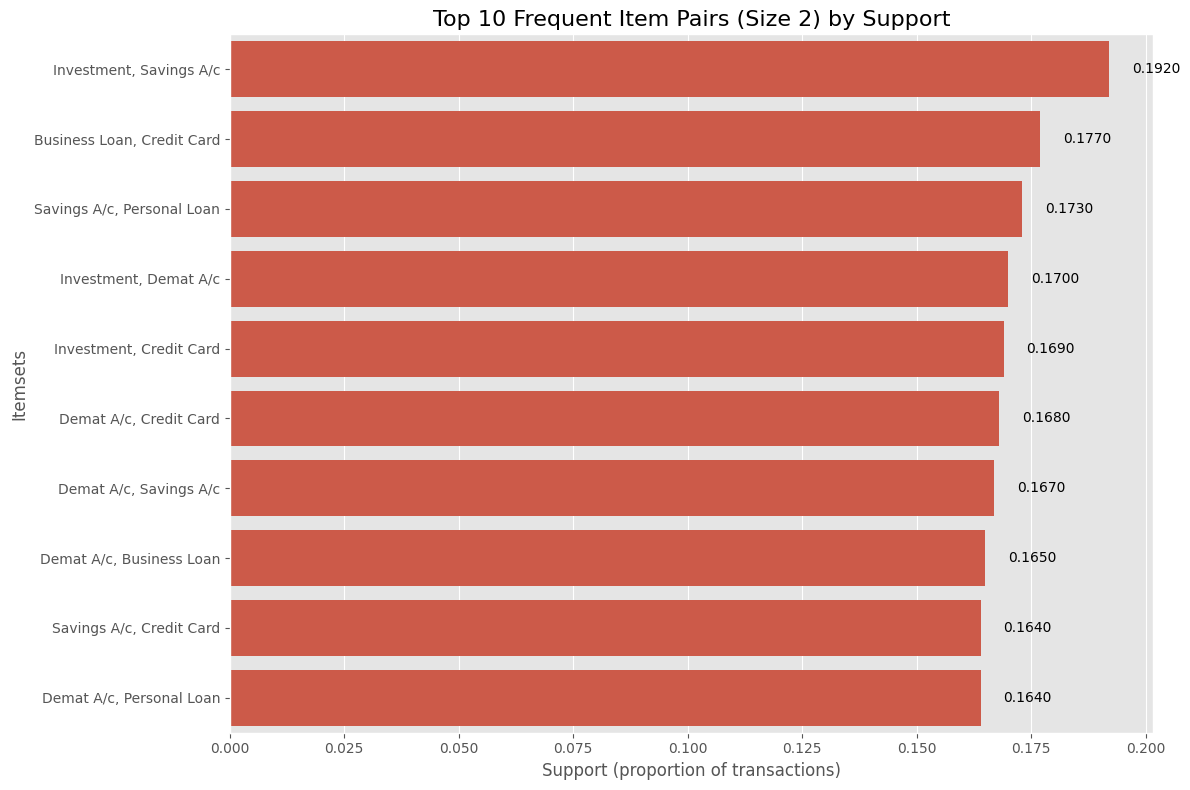

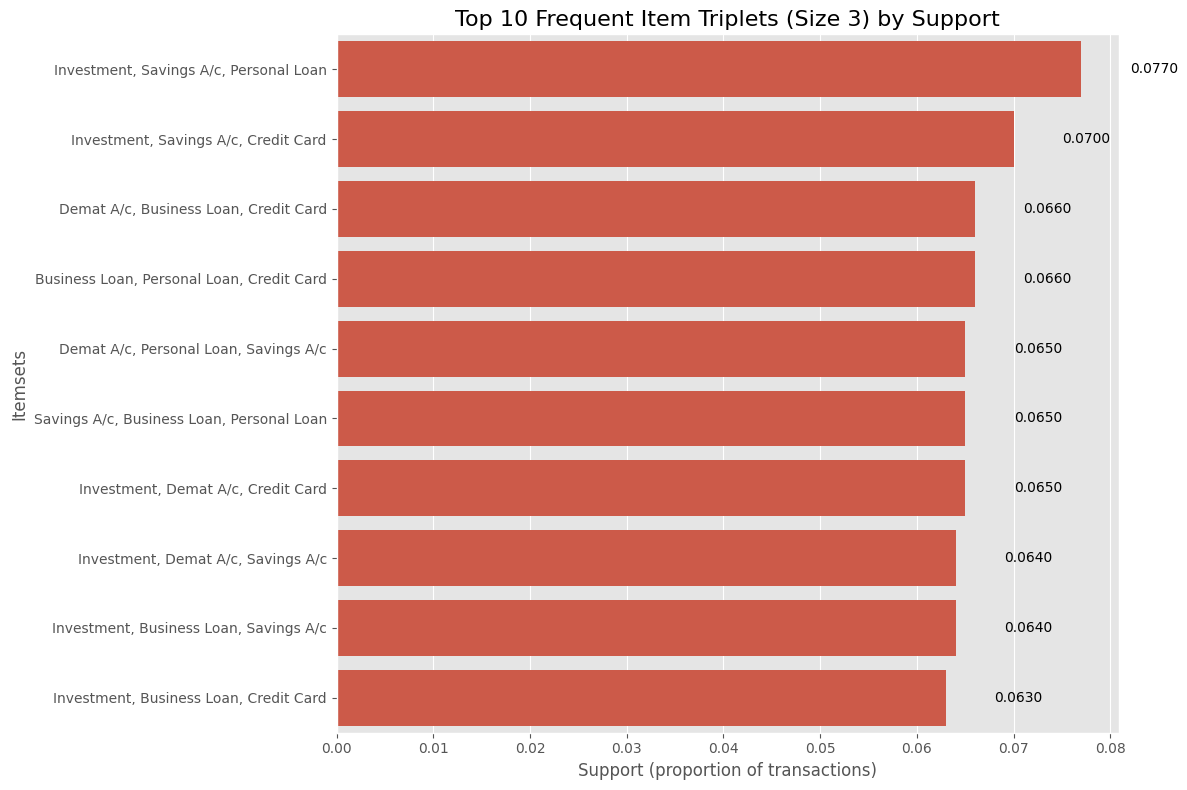

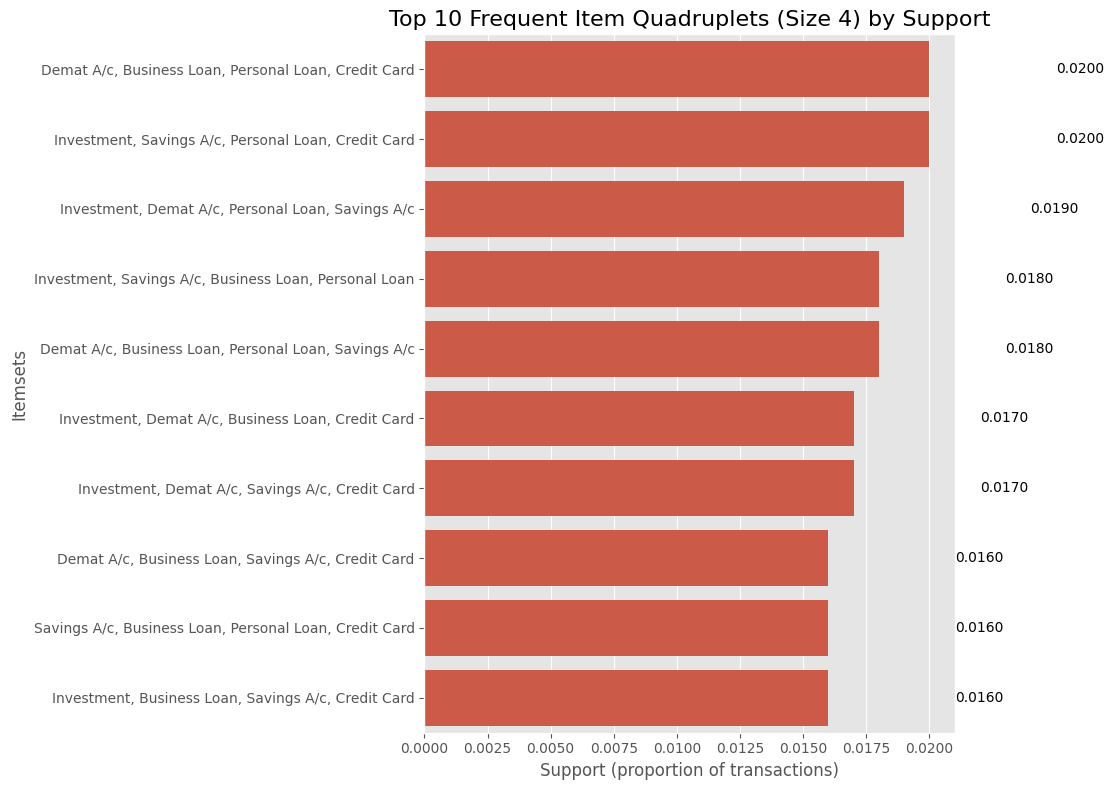


Enter minimum confidence threshold for rules (0-1, default: 0.5): 0.5

===== ASSOCIATION RULES ANALYSIS =====
Generating rules with minimum confidence = 0.5
No rules found with the given threshold. Try reducing the confidence threshold.

Analysis complete!


In [7]:
# Main function
def main():
    # Ask for the file path
    file_path = input("Enter the path to your CSV file (or press Enter to use 'transactions.csv'): ")
    if not file_path:
        file_path = "transactions.csv"

    # Load data
    print(f"\nLoading data from {file_path}...")
    transactions = load_and_prepare_data(file_path)

    if transactions is None:
        return

    # Ask for minimum support threshold
    min_support_input = input("\nEnter minimum support threshold (0-1, default: 0.01): ")
    min_support = 0.01
    if min_support_input:
        try:
            min_support = float(min_support_input)
            if min_support <= 0 or min_support > 1:
                print("Invalid support value. Using default value of 0.01.")
                min_support = 0.01
        except ValueError:
            print("Invalid input. Using default value of 0.01.")

    # Run apriori algorithm
    frequent_itemsets = market_basket_analysis(transactions, min_support)

    if frequent_itemsets is None:
        return

    # Analyze itemsets by size
    pairs, triplets, quadruplets = analyze_itemsets_by_size(frequent_itemsets)

    # Visualize results
    visualize_itemsets(pairs, triplets, quadruplets)

    # Generate association rules
    min_confidence_input = input("\nEnter minimum confidence threshold for rules (0-1, default: 0.5): ")
    min_confidence = 0.5
    if min_confidence_input:
        try:
            min_confidence = float(min_confidence_input)
            if min_confidence <= 0 or min_confidence > 1:
                print("Invalid confidence value. Using default value of 0.5.")
                min_confidence = 0.5
        except ValueError:
            print("Invalid input. Using default value of 0.5.")

    rules = generate_association_rules(frequent_itemsets, min_confidence)

    print("\nAnalysis complete!")

    # Return results for possible further analysis
    return transactions, frequent_itemsets, rules

if __name__ == "__main__":
    main()